# HMM and Reinforcement Learning Experiments

This notebook demonstrates advanced experiments for the **Probabilistic Stock Trading Agent** project. In these experiments we:

1. **HMM Integration:**
   - Compute technical indicators (MA, RSI, MACD) on the processed data.
   - Fit a Gaussian Hidden Markov Model (HMM) on these indicators to infer latent market regimes.
   - Visualize the inferred regimes for a subset of observations.
   - Compare the effects of using 2, 3, or 4 latent states.

2. **Reinforcement Learning (Q-Learning):**
   - Simulate a simple trading environment using processed data with discretized features and the inferred `Market_Regime`.
   - Train a Q-learning agent with an epsilon‑greedy policy.
   - Plot the cumulative reward per episode to observe the learning progress.

These experiments validate the advanced feature engineering and modeling improvements introduced in Milestone 3.

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import project modules
from technical_indicators import add_technical_indicators
from hmm_integration import fit_hmm_on_indicators
from rl_agent import QLearningAgent, SimpleTradingEnv
from hmmlearn.hmm import GaussianHMM

# Set random seed for reproducibility
np.random.seed(42)

## 1. HMM Integration Experiment

In this section we load the processed stock data, ensure that technical indicators (MA_20, RSI_14, MACD) are available, and fit a Gaussian HMM. The HMM clusters the data into latent market regimes that will later be incorporated as a feature in our Bayesian network and RL experiments.

We will:
- Load and inspect the data.
- Fit the HMM on the technical indicators.
- Visualize the inferred `Market_Regime` for the first 300 observations.
- Compare different numbers of latent states.

In [35]:
# Load processed data (adjust the file path as needed)
processed_file = '../data/processed/all_stocks_2006-01-01_to_2018-01-01.csv'
df = pd.read_csv(processed_file)
print(f"Processed Data Shape: {df.shape}")

# Ensure the required technical indicators are present
required_indicators = ['MA_20', 'RSI_14', 'MACD']
for indicator in required_indicators:
    if indicator not in df.columns:
        df = add_technical_indicators(df)

# Drop rows with missing indicator values for reliable HMM fitting
df_hmm = df.dropna(subset=required_indicators).copy()
print(f"Data shape for HMM fitting (after dropping NaNs): {df_hmm.shape}")

Processed Data Shape: (93593, 17)
Data shape for HMM fitting (after dropping NaNs): (93593, 17)


### Fit Gaussian HMM on Technical Indicators

We use a Gaussian HMM with 3 latent states (as experiments showed that 3 states provide the best balance). The inferred state is added to the data as the `Market_Regime` feature.

In [36]:
# Prepare data for HMM fitting
X = df_hmm[required_indicators].values
n_components = 3  # Experimentally determined optimal number of states

# Fit the Gaussian HMM
hmm_model = GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=100, random_state=42)
hmm_model.fit(X)
latent_states = hmm_model.predict(X)
df_hmm['Market_Regime'] = latent_states

### Visualize Inferred Market Regimes

We plot the inferred market regimes for the first 300 observations to see how the latent states change over time.


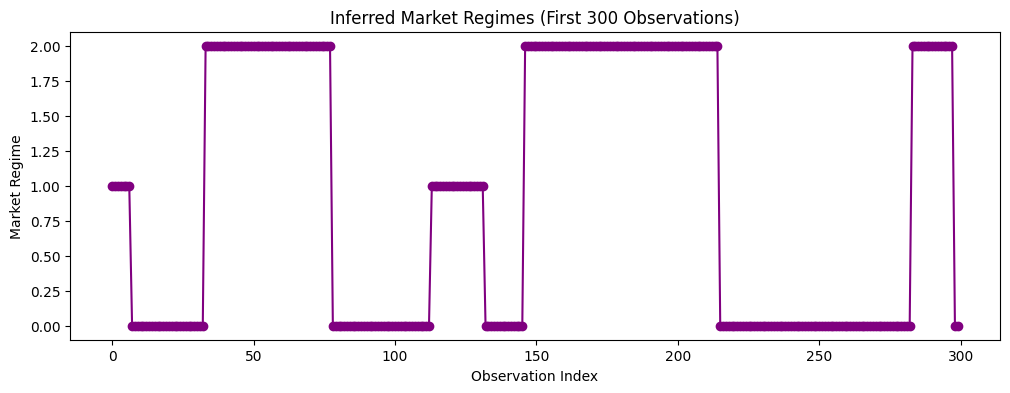

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(df_hmm.index[:300], df_hmm['Market_Regime'][:300], marker='o', linestyle='-', color='purple')
plt.xlabel('Observation Index')
plt.ylabel('Market Regime')
plt.title('Inferred Market Regimes (First 300 Observations)')
plt.show()

### Compare Different Latent State Configurations

We compare the state counts when fitting the HMM with 2, 3, and 4 latent states. This helps us understand how the number of states affects the distribution.

In [38]:
print("Comparing latent state counts for different configurations:")
for n in [2, 3, 4]:
    model = GaussianHMM(n_components=n, covariance_type='diag', n_iter=100, random_state=42)
    model.fit(X)
    states = model.predict(X)
    unique, counts = np.unique(states, return_counts=True)
    
    # Convert using a dictionary comprehension
    state_counts = {int(k): int(v) for k, v in zip(unique, counts)}
    
    print(f"Number of States: {n} -> State Counts: {state_counts}")


Comparing latent state counts for different configurations:
Number of States: 2 -> State Counts: {0: 21368, 1: 72225}
Number of States: 3 -> State Counts: {0: 40787, 1: 10204, 2: 42602}
Number of States: 4 -> State Counts: {0: 6523, 1: 33076, 2: 27059, 3: 26935}


## 2. Reinforcement Learning (Q-Learning) Experiment

In this section, we simulate a simple trading environment using processed data that includes discretized features and the inferred `Market_Regime`. A Q-learning agent with an epsilon‑greedy policy is trained in this environment. The total cumulative reward per episode is recorded and plotted to produce a learning curve.

### Preparing Data for RL

We select the key features for the trading simulation and use a subset of the data for faster experimentation.

In [39]:
# Select the RL features
rl_features = ['Open_binned', 'High_binned', 'Low_binned', 'Market_Regime']
df_rl = df.dropna(subset=rl_features).copy()
print(f"RL Data Shape: {df_rl.shape}")

# For simulation purposes, take a sample (e.g., first 500 observations)
df_rl_sample = df_rl.head(500).reset_index(drop=True)

RL Data Shape: (93593, 17)


### Initialize Environment and Q-Learning Agent

We use the `SimpleTradingEnv` defined in our project along with the Q-learning agent. Adjust hyperparameters (`alpha`, `gamma`, `epsilon`) as needed.


In [40]:
# Initialize the simple trading environment with the sample data
env = SimpleTradingEnv(df_rl_sample)

# Initialize the Q-learning agent with chosen hyperparameters
agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=0.1)

### Simulate Episodes and Record Learning Curve

We simulate a set number of episodes, record the total reward per episode, and plot the learning curve to observe the agent's performance improvement over time.

Episode 1: Total Reward = -0.044736327356500655
Episode 2: Total Reward = 0.018251902407903725
Episode 3: Total Reward = 0.016609462740552694
Episode 4: Total Reward = 0.02423653022768424
Episode 5: Total Reward = -0.026417836137397788
Episode 6: Total Reward = 0.003802183782036783
Episode 7: Total Reward = 0.06074242291531379
Episode 8: Total Reward = 0.07858297458212946
Episode 9: Total Reward = 0.05095232504351041
Episode 10: Total Reward = 0.04403192996085628
Episode 11: Total Reward = 0.06733741396315526
Episode 12: Total Reward = 0.050931353431368204
Episode 13: Total Reward = 0.03818906612352099
Episode 14: Total Reward = 0.05218315391632797
Episode 15: Total Reward = 0.05013906772933205
Episode 16: Total Reward = 0.031199629988272665
Episode 17: Total Reward = 0.051514494494546315
Episode 18: Total Reward = 0.021025454042753577
Episode 19: Total Reward = 0.014372901876560679
Episode 20: Total Reward = 0.06697746703691523
Episode 21: Total Reward = 0.031085321753915013
Episode 2

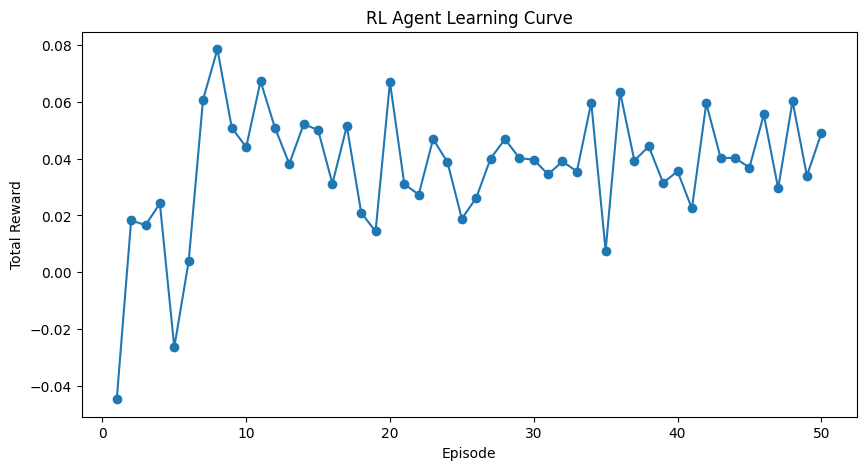

In [41]:
episodes = 50
episode_rewards = []

for ep in range(episodes):
    total_reward = agent.simulate_episode(env, max_steps=100)
    episode_rewards.append(total_reward)
    print(f"Episode {ep+1}: Total Reward = {total_reward}")

# Plot the RL agent learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, episodes+1), episode_rewards, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('RL Agent Learning Curve')
plt.show()

## Conclusion

In this notebook we:

- **HMM Integration:**  
  - Loaded processed stock data and ensured technical indicators (MA_20, RSI_14, MACD) were computed.
  - Fitted a Gaussian HMM to infer latent market regimes, adding the `Market_Regime` feature.
  - Visualized the latent states for the first 300 observations and compared different state configurations (2, 3, and 4 states).

- **RL Q-Learning Experiment:**  
  - Set up a simple trading environment using discretized features and the inferred `Market_Regime`.
  - Trained a Q-learning agent and plotted its learning curve, showing cumulative reward per episode.
  
These experiments validate our advanced feature engineering, probabilistic modeling improvements, and demonstrate promising paths for further developing adaptive trading strategies.